In [1]:
!pip install spacy

In [2]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 59.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [22]:
import pandas as pd
# Load dataset
df = pd.read_csv('Tweets.csv')  # make sure the file is downloaded and in your working directory
print(df.columns)
df = df[['text', 'airline_sentiment', 'tweet_created', 'airline']]  # Keep only needed columns, including 'tweet_created' and 'airline'
df.head()

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')


,text,airline_sentiment,tweet_created,airline
0,@VirginAmerica What @dhepburn said.,neutral,2015-02-24 11:35:52 -0800,Virgin America
1,@VirginAmerica plus you've added commercials t...,positive,2015-02-24 11:15:59 -0800,Virgin America
2,@VirginAmerica I didn't today... Must mean I n...,neutral,2015-02-24 11:15:48 -0800,Virgin America
3,@VirginAmerica it's really aggressive to blast...,negative,2015-02-24 11:15:36 -0800,Virgin America
4,@VirginAmerica and it's a really big bad thing...,negative,2015-02-24 11:14:45 -0800,Virgin America


In [4]:
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")
def preprocess(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.text not in string.punctuation and
           token.lemma_ not in STOP_WORDS and
           token.is_alpha
    ]
    return " ".join(tokens)
df['clean_text'] = df['text'].apply(preprocess)
df[['text', 'clean_text']].head()

,text,clean_text
0,@VirginAmerica What @dhepburn said.,
1,@VirginAmerica plus you've added commercials t...,plus add commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,I today mean I need trip
3,@VirginAmerica it's really aggressive to blast...,aggressive blast obnoxious entertainment guest...
4,@VirginAmerica and it's a really big bad thing...,big bad thing


In [5]:
import numpy as np

df['word_count'] = df['clean_text'].apply(lambda x: len(x.split())) #Splits each cleaned tweet into words and counts them.
df['char_count'] = df['clean_text'].apply(len) #Counts total characters in each cleaned tweet (no spaces removed).
df['avg_word_len'] = df['clean_text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x else 0) #For each tweet:Splits into words, Measures the length of each word,Takes the average word length.
#If the tweet is empty, it returns 0.
df['has_exclaim'] = df['text'].str.contains("!").astype(int) #Uses .str.contains() to find if ! or ? exists in the original (raw) tweet.Converts True/False to 1/0 using .astype(int)
df['has_question'] = df['text'].str.contains("\?").astype(int)
df['has_hashtag'] = df['text'].str.contains("#").astype(int) #Detects the presence of hashtags (#) and mentions (@) in tweets.
df['has_mention'] = df['text'].str.contains("@").astype(int)

from textblob import TextBlob

Imports the TextBlob class from the TextBlob library, which simplifies text processing and sentiment analysis.

TextBlob(x).sentiment

This returns a Sentiment object with two attributes:

polarity (range: -1 to +1)

subjectivity (range: 0 to 1)

## polarity:

Measures how positive or negative the text is.

-1 = very negative
0 = neutral
+1 = very positive

##subjectivity:

Measures how subjective or opinionated the text is.

0 = fully objective (facts)
1 = fully subjective (opinions, feelings)

Why We Use polarity and subjectivity for Sentiment Classification
Feature	Helps Identify
Polarity	Whether a tweet is positive, negative, or neutral.
Subjectivity	Whether a tweet is factual (low) or opinionated (high).

In the Airline Sentiment Dataset:
A tweet like "Flight was on time and smooth" → polarity = +0.6 → positive

"I hate @united, worst service ever" → polarity = -0.9 → negative

"Boarding started at 6:30" → polarity ≈ 0, subjectivity ≈ 0 → neutral/factual



In [6]:
from textblob import TextBlob

df['polarity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1800)
tfidf_matrix = tfidf.fit_transform(df['clean_text'])

# Convert to DataFrame for later analysis (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())


/tmp/ipython-input-11-3805783064.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='airline_sentiment', palette='Set1')


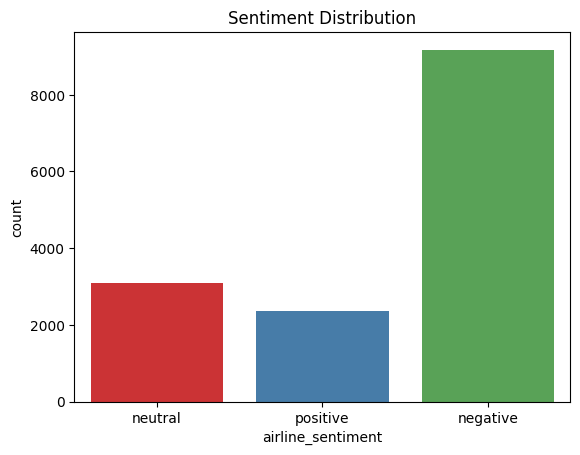

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='airline_sentiment', palette='Set1')
plt.title("Sentiment Distribution")
plt.show()

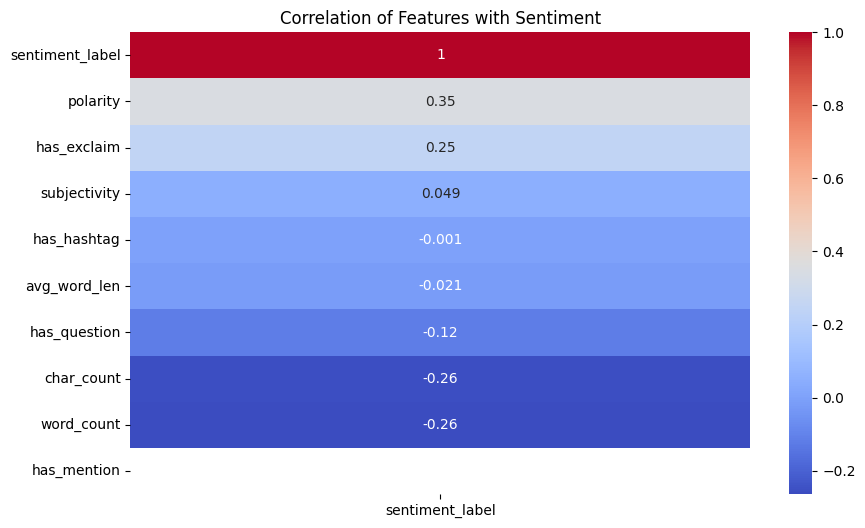

In [13]:
from sklearn.preprocessing import LabelEncoder

# Encode sentiments to numeric labels
le = LabelEncoder()
df['sentiment_label'] = le.fit_transform(df['airline_sentiment'])  # 0=negative, 1=neutral, 2=positive

# Correlation matrix of basic features
feature_cols = ['word_count', 'char_count', 'avg_word_len',
                'has_exclaim', 'has_question', 'has_hashtag', 'has_mention',
                'polarity', 'subjectivity']
correlation = df[feature_cols + ['sentiment_label']].corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation[['sentiment_label']].sort_values(by='sentiment_label', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Correlation of Features with Sentiment')
plt.show()

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

for sentiment in df['airline_sentiment'].unique():
    print(f"Top words for {sentiment.upper()}:")
    top_words = get_top_n_words(df[df['airline_sentiment'] == sentiment]['clean_text'], 10)
    for word, freq in top_words:
        print(f"{word}: {freq}")
    print('-' * 40)


Top words for NEUTRAL:
flight: 796
thank: 219
need: 186
help: 170
fly: 169
dm: 123
ticket: 114
know: 113
change: 113
time: 111
----------------------------------------
Top words for POSITIVE:
thank: 1060
flight: 444
great: 238
good: 215
service: 164
fly: 153
love: 152
customer: 123
guy: 123
help: 114
----------------------------------------
Top words for NEGATIVE:
flight: 3495
hour: 1088
cancel: 920
delay: 899
customer: 780
service: 774
time: 748
hold: 677
help: 662
bag: 660
----------------------------------------


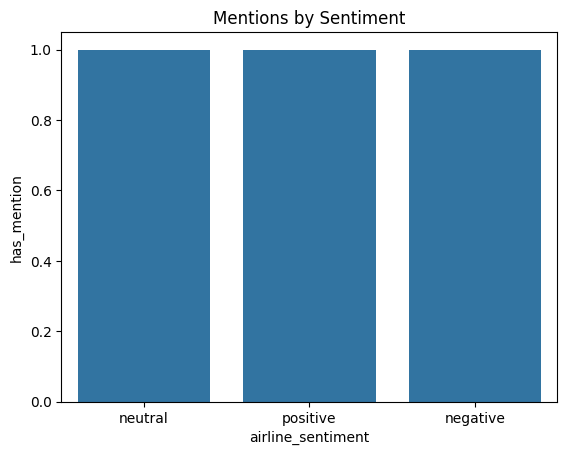

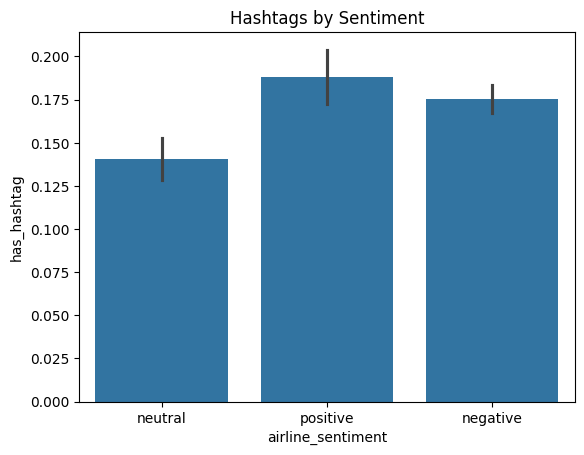

In [15]:
sns.barplot(data=df, x='airline_sentiment', y='has_mention')
plt.title("Mentions by Sentiment")
plt.show()

sns.barplot(data=df, x='airline_sentiment', y='has_hashtag')
plt.title("Hashtags by Sentiment")
plt.show()

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'tweet_created' exists and convert to datetime
df['tweet_created'] = pd.to_datetime(df['tweet_created'], errors='coerce')

# Drop rows with invalid or missing datetime
df = df.dropna(subset=['tweet_created'])

# Extract hour from datetime
df['hour'] = df['tweet_created'].dt.hour

# Check if 'airline_sentiment' column exists
if 'airline_sentiment' in df.columns:
    sns.histplot(data=df, x='hour', bins=24, hue='airline_sentiment', multiple='stack', palette='Set1')
    plt.title("Tweet Volume by Hour and Sentiment")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Tweets")
    plt.xticks(range(0, 24))
    plt.show()
else:
    print("Column 'airline_sentiment' not found in the DataFrame.")

KeyError: 'tweet_created'

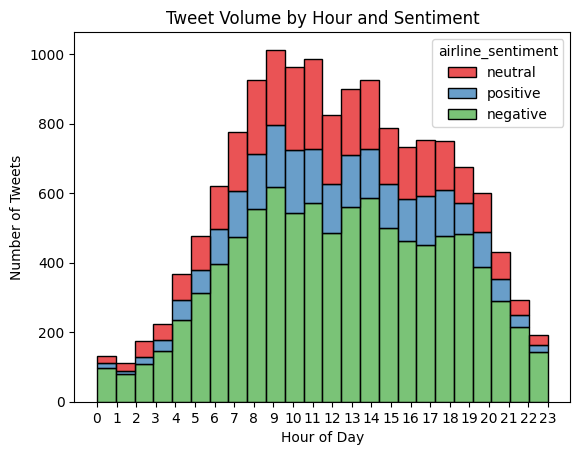

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'tweet_created' exists and convert to datetime
df['tweet_created'] = pd.to_datetime(df['tweet_created'], errors='coerce')

# Drop rows with invalid or missing datetime
df = df.dropna(subset=['tweet_created'])

# Extract hour from datetime
df['hour'] = df['tweet_created'].dt.hour

# Check if 'airline_sentiment' column exists
if 'airline_sentiment' in df.columns:
    sns.histplot(data=df, x='hour', bins=24, hue='airline_sentiment', multiple='stack', palette='Set1')
    plt.title("Tweet Volume by Hour and Sentiment")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Tweets")
    plt.xticks(range(0, 24))
    plt.show()
else:
    print("Column 'airline_sentiment' not found in the DataFrame.")

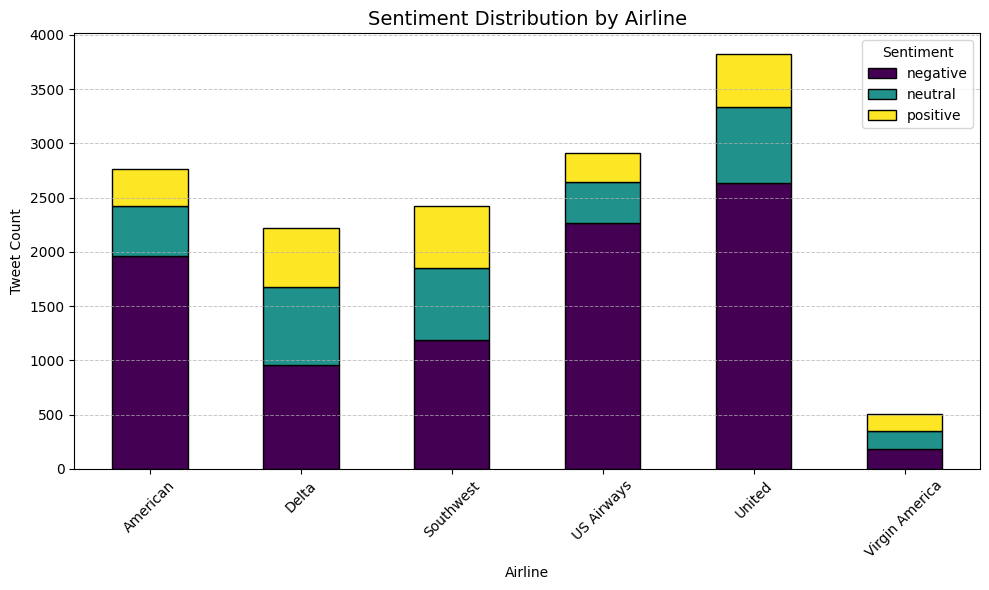

In [23]:
# Drop rows with missing 'airline' or 'airline_sentiment' to prevent plotting issues
df_clean = df.dropna(subset=['airline', 'airline_sentiment'])

# Create a crosstab of airline vs sentiment
airline_sentiment_counts = pd.crosstab(df_clean['airline'], df_clean['airline_sentiment'])

# Sort airlines alphabetically for cleaner plot
airline_sentiment_counts = airline_sentiment_counts.sort_index()

# Plot
airline_sentiment_counts.plot(
    kind='bar',
    stacked=True,
    colormap='viridis',
    figsize=(10, 6),
    edgecolor='black'
)

plt.title("Sentiment Distribution by Airline", fontsize=14)
plt.ylabel("Tweet Count")
plt.xlabel("Airline")
plt.xticks(rotation=45)
plt.legend(title="Sentiment", loc='upper right')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [24]:
sentiment_map = {'negative': -1, 'neutral': 0, 'positive': 1}
df['sentiment_label'] = df['airline_sentiment'].map(sentiment_map)